Classification and Feature Engineering
===============================

Workflow set up
-------------------

As before, we'll begin by loading our `spaCy` model.

In [1]:
import spacy

nlp = spacy.load('en_core_web_md')

Later on we're going to do some work with sentiment analysis. `spaCy` can help us with this to an extent, but the default pipeline of the model does not include a sentiment component. You can check which processes a model will run on a document with the following:

In [2]:
for name in nlp.component_names:
    print(name)

tok2vec
tagger
parser
senter
ner
attribute_ruler
lemmatizer


### Changing `spaCy` pipeline components

We'll need to **add a pipe** to the pipline. In this case, we're using a sentiment analysis tool that's been ported over from the [TextBlob] library (which is itself a useful tool for NLP!). Adding it to the pipeline is simply a matter of using `nlp.add_pipe()`.

[TextBlob]: https://textblob.readthedocs.io/en/dev/

In [3]:
from spacytextblob.spacytextblob import SpacyTextBlob

nlp.add_pipe('spacytextblob')

Now, if we run through the component names, we'll see that the model performs sentiment analysis when it processes documents. Adding pipes defaults to putting them at the end of all other components, but it's also possible to change their order.

In [4]:
for name in nlp.component_names:
    print(name)

tok2vec
tagger
parser
senter
ner
attribute_ruler
lemmatizer
spacytextblob


It's also possible to remove model components. You might do so if you know you don't need certain kinds of information about your documents. For example, in this session we won't be doing any named entity recognition, so we'll drop this component from the pipeline. This will shorten our procesing time and it will decrease the amount of data associated with each document.

In [5]:
nlp.remove_pipe('ner')

assert 'ner' in nlp.component_names, 'Named entity recognition is no longer in the pipeline!'

AssertionError: Named entity recognition is no longer in the pipeline!

Later on we'll discuss how to use the extra component we've just added to our model. But for now, let's move on to loading our corpus.

### Generating labels

First off, we need to make some labels. Each file is labeled with its text genre. We'll go through every file name and extract that information to build a list of labels, which we'll later associate with our corpus.

```{margin} What this loop does:

1. Use `glob` to get all `.txt` filepaths
2. Use `re.findall()` to determine which genre name is in the filepath
3. Append a corresponding integer to a list of labels. This list will be in the same order as our files (an important alignment for later work)
```

In [6]:
import glob
import re

paths = glob.glob('data/session_two/corpus/*.txt')
paths.sort()

labels = []
for path in paths:
    if re.findall('fiction', path):
        labels.append(1)
    elif re.findall('summaries', path):
        labels.append(2)
    else:
        labels.append(3)
        
label_dict = {1: 'fiction', 2: 'summary', 3: 'abstract'}

### Lazy loading

With this done, we can load and process our files. There are around 250 of them, and some are fairly long. To handle this, we'll use a slightly different process than what we've been doing so far. Instead of loading everything into memory all at once, we'll incrementally stream in files using a **generator** and let `spaCy` automatically call up the next file when it's finished processing. This is called **lazy loading**. It's a good idea to do this kind of thing when you're working with large corpora: it's far more memory efficient, and it saves you the trouble of needing to write a bunch of `for` loops to manage the preprocessing work.

The code is fairly straightforward. All we need to do is send a function our filepaths and have it `yield` out opened files.

In [7]:
def lazy_load(paths):
    for path in paths:
        doc = open(path, 'r')
        yield doc.read()
        
doc_pointer = lazy_load(paths)

There is a downside to this, however: remember that generators just point to the next object; they only work with the data represented by that pointer when some process is called. Accordingly, this can make it difficult to poke around in your data, since here:

In [8]:
doc_pointer

<generator object lazy_load at 0x156931840>

...all we see is the pointer. To know what's actually in the corpus, you'd need to call in an instance, with `next()`:

In [9]:
doc = next(doc_pointer)
print(doc[:100])

Adventure V. The Musgrave Ritual


An anomaly which often struck me in the character of my friend Sh


Luckily, `spaCy` is good at handling this sort of thing. All we need to do is wrap our paths in `lazy_load()` and send this to a function called `nlp.pipe()`. The latter will go through our generator and process each document when it's ready to do so.

In [10]:
to_process = nlp.pipe(lazy_load(paths))

Preprocessing
-----------------

With our model, labels, and loading function all set up, we can start processing our files. We're going to use a fairly simple cleaning function to weed out extra cruft in our documents. For every document, this function – which we'll call `clean()` – will return a list of lowercased and lemmatized words (provided these words aren't stop words!).

```{margin} Details about our cleaning function

For every token in a document:

1. Check if the token contains alphabetic characters
2. If it does, check to see whether it's a stopword or whether it's less than two characters long
3. If it isn't, get its lemma, then convert it to lowercase
4. Append the converted token to `cleaned`
```

In [11]:
def clean(doc):
    cleaned = []
    for token in doc:
        if token.is_alpha:
            if token.is_stop == False and len(token) > 2:
                token = token.lemma_
                token = token.lower()
                cleaned.append(token)
                
    return cleaned

Now, we can use a simple list comprehension to clean our entire corpus. This will load every file, send it through `spaCy`, and then send it through our custom cleaning function.

In [12]:
cleaned = [clean(doc) for doc in to_process]

Another reason for using a lazy loader on our files has to do with later work we'll do in this session: though our work so far has involved creating _bag of words_ representations of the corpus, later steps will require full text representations. With `lazy_load()` written, we can easily reprocess our corpus whenever we'd like.

Modeling I: tf-idf
-------------------

Feature Engineering
------------------------

SOME PRELIMINARY REMARKS

There are two key aspects of feature engineering. You need to know:

1. What you want to learn about your corpus
2. What kind of features might characterize your corpus

The first point is straightforward, but very important. Your underlying research question needs to drive your computational work. Though we're working in an exploratory mode, there's actually a research question here: what features best characterize the different genres in our corpus?

The second point is a little fuzzier. It's likely that you'll know at least a few things about your corpus, before you even load it into Python. For instance, even knowing where the data comes from can serve as an important frame with which to begin asking informed questions. While there's always going to be some fishing involved in exploratory work, you can keep your explorations somewhat focused by leveraging your prior knowledge about your data.

In our case, we already know that there are three different genres in our corpus. We also know in a general sense some things about each of these genres. Abstracts, for example, are brief, fairly objective documents; often, they're written in the third person with passive voice. The same goes for plot summaries, though we might expect the formality of the language in summaries to be different than abstracts. On the other hand, fiction tends to be longer than the other two genres, and it also tends to have a more varied vocabulary.

To be sure, these are general assumptions, which may or may not mesh with our actual corpus. But they're a good starting point, and we can write some code to generate metrics that will show whether our assumptions are, in fact, correct.

We'll do so in two passes. Our **first set of features** will rely on the cleaned, bag-of-word representations of the corpus documents, which we've already produced above. **The second**, on the other hand, will collect information about things like grammatical structure or part-of-speech tags, and thus they will require us to use full, as-is representations of our documents.

### Document length

The first of our metrics is a simple one: document length. Document length is a surprisingly effective indicator of different genres, and, even better, it's very easy information to collect. In fact, there's no need to write custom code; we can just use `len()`.

### Lexicon I: hapax richness

With our document length function written, we can use its output to create another metric, called **hapax richness**. If you'll recall from the [second day] of our Getting Started with Textual Data workshop series, a hapax (short for "hapax legomenon") is a word that occurs only once in a document. Researchers, especially those working in authorship attribution, will use such words to create a measure of a document's lexical complexity: the more hapaxes in a document, the more lexically complex that document is said to be.

Generating a hapax richness metric involves finding all hapaxes in a document. Once we've done so, we simply take the sum of those tokens over the total number of tokens in a document.

[second day]: https://ucdavisdatalab.github.io/workshop_getting_started_with_textual_data/04_corpus-analytics.html#raw-metrics-terms

```{margin} Using a Counter

A `Counter` is a subclass of the standard Python dictionary. They're very useful for tracking the frequency of items in some collection of data. Here, we simply wrap a document inside a `Counter` and Python will automatically convert that document's tokens into frequency data. This enables us to take a subset of those tokens with ease.
```

In [13]:
from collections import Counter

def hapax_richness(doc, doc_len):
    tokens = Counter(doc)
    hapaxes = Counter(token for token, count in tokens.items() if count == 1)
    n_hapaxes = sum(hapaxes.values())
    
    return n_hapaxes / doc_len

### Inspecting our work

Now that we have two methods of generating metrics about our corpus, let's run each document through them and put the results in a `pandas` dataframe. We'll also include the labels from before, which will require us to `zip` the document list together with the list that contains our labels.

In [14]:
import pandas as pd

basic_features = []
for doc, label in zip(cleaned, labels):
    doc_len = len(doc)
    hapax = hapax_richness(doc, doc_len)
    basic_features.append({
        'LENGTH': doc_len,
        'HAPAX': hapax,
        'LABEL': label
    })
    
basic_features = pd.DataFrame(basic_features)
basic_features['LABEL_NAME'] = basic_features['LABEL'].replace(label_dict)

Let's take a look:

In [15]:
basic_features.groupby('LABEL').sample(2)

,LENGTH,HAPAX,LABEL,LABEL_NAME
44,5794,0.173110,1,fiction
31,4464,0.207885,1,fiction
56,15,0.866667,2,summary
110,47,0.744681,2,summary
253,196,0.622449,3,abstract
193,790,0.217722,3,abstract


There are a few ways to inspect our work more closely and determine whether these are meaningful features. All of them will leverage the `.groupby()` in `pandas` to partition subsets of the data and investigate the feature distributions therein. Throughout, we're interested in identifying features that seem to be different for each label type.

You may find simple metrics like the mean distrubtions for features to be useful:

In [16]:
basic_features.groupby('LABEL_NAME')[['LENGTH', 'HAPAX']].mean()

,LENGTH,HAPAX
LABEL_NAME,,
abstract,547.980000,0.346419
fiction,3286.678571,0.250794
summary,178.930000,0.630816


There's some nice separability here!

Determing whether features are correlated is also useful. We can break out by-label correlations with the following:

In [17]:
basic_features.groupby('LABEL_NAME')[['LENGTH', 'HAPAX']].corr()

LENGTH     HAPAX
LABEL_NAME                           
abstract   LENGTH  1.000000 -0.337493
           HAPAX  -0.337493  1.000000
fiction    LENGTH  1.000000 -0.882208
           HAPAX  -0.882208  1.000000
summary    LENGTH  1.000000 -0.778418
           HAPAX  -0.778418  1.000000

It makes sense that length and hapax richness tend to be negatively correlated: the longer a text is, the more likely we are to see repeated words. In this sense, as it stands our hapax feature might not be as representative as we'd like it to be, especially when it comes to a document class like fiction. Surely there are rare, potentially important words in the fiction, but they're largely blurred by the length of the documents. To mitigate this, we could use a **window size** to determine hapax richness, modifying the code above, for example, to break texts into smaller chunks and get a mean hapax score for all chunks. We won't do this now, but keep in mind that you may have to make such modifications when engineering features.

Raw metrics are useful, but so are visualizations. Below, we put together a quick function to show the by-label distribution of features in our data. The resultant histograms will make it clear whether our features are actually helping to partition our data, or whether they're just muddling distinctions between document classes even more.

```{margin} What our graphing function does:

1. Create a `matplotlib` subplots figure and axis
2. Group the dataframe by a column and then iterate through the group name and group data, targeting a feature we'd like to inspect
3. Create a histogram showing the number of documents with a certain value range for the feature

Note: we're using a little scaling on the bins to correct for the class imbalances.
```

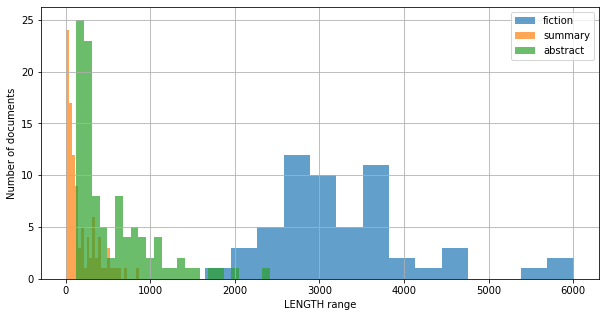

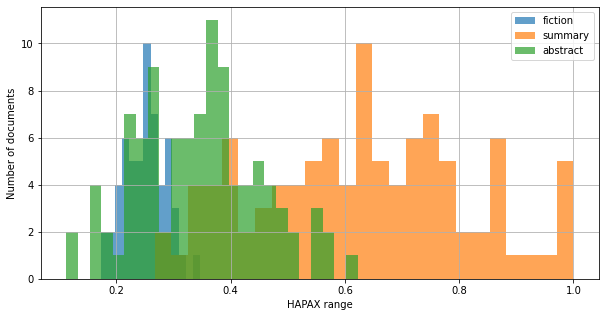

In [18]:
import matplotlib.pyplot as plt

def graph_dist(df, feature, groupby='LABEL', label_dict=label_dict):
    fig, ax = plt.subplots(figsize=(10,5))
    
    for (i, d) in df.groupby(groupby):
        n_bins = round(len(d) * .25)
        d[feature].hist(ax=ax, label=i, alpha=0.7, bins=n_bins)
        ax.legend(list(label_dict.values()))
        ax.set_ylabel("Number of documents")
        ax.set_xlabel(f"{feature} range")
        
    return fig

for feat in ['LENGTH', 'HAPAX']:
    graph_dist(basic_features, feat);

These histograms usefully show us divisions among our classes. While the document lengths of summaries and abstracts have a similar shape and magnitude, there's good separability between their two distributions in the hapax richness scores. And throughout, documents labeled with fiction are notably different from the other two classes; a classifier is sure to register this. Indeed, this difference could serve as a counter to the suggestion above about creating a window size for hapax richness. Though windowing the documents might create a more realistic representation, we're already seeing useful separability within the hapax metric as it stands. In this sense, you might approach feature engineering with a fair bit of pragmatism, especially with regard to the wider goals of your research question. It may be that the fact that there's a difference at all is enough, regardless of whether it's the best, most nuanced representation of your data.

For our purposes, what we have so far is, in fact, enough. We can feel pretty confident that the two features we've engineered so far will serve as useful metrics for a classifier, which is our ultimate intent for our session. With this established, it's time to move on to more complex metrics: ones that depend on full text representations of the documents.

### Active vs. passive voice

The reason the following metrics are more complex is twofold. First, they require a little bit more in the way of coding than the ones above; and second, they require us to think more carefully about relationships across our corpus (often with a fair bit of hypothesizing!). To wit: the first of our full text metrics concerns the distinction between active and passive voice. The hypothesis here is that the objective, report-like nature of abstracts (and perhaps summaries) will have more passive voice overall than in fiction, which tends to be focused on present action. To measure this, we'll use `spaCy`'s dependency parser to identify the percentage of passive voice subjects in a document, versus active subjects.

We'll implement this in a function, which will tally the number of passive subjects and the number of active subjects in each sentence of the document. Then, it will sum together the total number of subjects and divide the number of passive subjects by that total. As above, we'll use a `Counter` to store the intermediary information generated throughout this function.

In [19]:
def score_passive(doc):
    subjects = Counter({'nsubjpass': 0, 'nsubj': 0})
    for sent in doc.sents:
        for token in sent:
            if token.dep_ in ('nsubjpass', 'nsubj'):
                subjects[token.dep_] += 1
    total_subjects = sum(subjects.values())
    
    return subjects['nsubjpass'] / total_subjects

### Lexicon II: abstract nouns

The code for our second metric will follow a similar structure to the code above. Below, we use `spaCy`'s part-of-speech tags to identify nouns in a document. Then we determine whether these are abstract nouns, on the theory that abstracts and summaries are likely to have more nouns that denote ideas, qualities, relationships, etc. than fiction.

But how do we find an abstract noun? One simple way is to consider a noun's suffix. Suffixes like _-acy_ or _-ism_ (e.g. accuracy, isomorphism) and _-hip_ or _-ity_ (e.g. relationship, fixity) are good, general markers of abstract nouns. They're not always a perfect match, but they can give us a general sense of what kind of noun it is that we're working with.

In [20]:
ABSTRACT_SUFFIX = ('acy', 'ncy', 'nce', 'ism', 'ity', 'ty', 'ent', 'ess', 'hip', 'ion')

def score_abstract(doc):
    nouns = Counter({'abstract': 0, 'not_abstract': 0})
    for token in doc:
        if token.pos_ == 'NOUN':
            if token.suffix_ in ABSTRACT_SUFFIX:
                nouns['abstract'] += 1
            else:
                nouns['not_abstract'] += 1
    total_nouns = sum(nouns.values())
    
    return nouns['abstract'] / total_nouns

### Lexicon III: cardinal numbers

So far we've been eliding potentially important differences between abstracts and summaries. Let's develop a metric that might help us distinguish between the two of them. One such metric could be a simple count of the number of cardinal numbers in a document: we'd expect summaries to have less than abstracts (whether because the latter reports various metrics, or because they often contain citations, dates, etc.). Using `spaCy`'s part-of-speech tagger will help us identify these tokens. Once identified, it's just a matter of incrementing a count.

In [21]:
def num_cardinals(doc):
    numbers = 0
    for token in doc:
        if token.tag_ == 'CD':
            numbers += 1
            
    return numbers

Note that we'll want to convert the return from this function into a percentage over total tokens. We'll do so in a later processing function that ties together everything we've written so far.

### Sentiment

The final metric we'll generate attempts to capture something about the sentiment of each document. **Sentiment analysis** is a popular NLP technique, which researchers use to determine affective and subjective information. Implementations vary, but most will assign a numeric value that represents the **polarity** of a text, that is, its general tendency toward negative, neutral, or positive sentiment. Typically, these values are a bounded range of `[-1, 1]`. Some implementations will also score the **subjectivity** of a text, with scores closer to `0` representing more "objective" texts and those tending toward `1` representing highly "subjective" texts.

The data and methods that drive sentiment analysis are highly varied. The newest implementations use deep learning models to capture fine-grained nuances in text strings, while older versions of the technique are lexicon-based. The latter usually score texts with a combination of rule-based matching and predetermined values for words.

If you use sentiment analysis, especially lexicon-based sentiment analysis (as we're doing here), it's important to keep in mind that the scores are, well, subjective. Someone had to go in and decide what _they_ thought the sentiment of words or phrases are. If you were to read the same text, you might not agree. When possible, try to find the dictionary that supplies the analyzer and get a sense of the classification rules that produce a value (for example, [here is the dictionary] that drives the `TextBlob` analyzer below). Good sentiment analysis toolkits will make this information readily available.

For our purposes, we'll generate a very simple sentiment metric. The `TextBlob` pipe we added to our model assigns scores for an entire document, individual sentences, or single spans and tokens. We'll use sentences. The code below goes through each sentence in the document, accesses its `._.polarity` attribute, and assigns that to a list. Then it takes the mean score of everything in the list.

[here is the dictionary]: https://github.com/sloria/TextBlob/blob/dev/textblob/en/en-sentiment.xml

In [25]:
import numpy as np

def score_polarity(doc):
    scores = []
    for sent in doc.sents:
        score = sent._.polarity
        scores.append(score)
        
    return np.mean(scores)

With all of our advanced feature engineering functions written, we can process our corpus. We'll call the above functions together using a single `get_stats()` function, which returns a dictionary of feature–value pairs.

```{margin} In a real life setting...

...you might use `get_stats()` to do your text cleaning and basic feature engineering as well. That would save you the trouble of processing your corpus twice.
```

In [23]:
def get_stats(doc):
    passivity = score_passive(doc)
    abstractness = score_abstract(doc)
    numbers = num_cardinals(doc)
    polarity = score_polarity(doc)
    
    return {
        'PASSIVITY': passivity,
        'ABSTRACTNESS': abstractness,
        'NUMBERS': numbers,
        'POLARITY': polarity
    }

As above, we use `lazy_load` in conjunction with `nlp.pipe()` and a list comprehension to produce a list of feature dictionaries. These we can easily convert into a dataframe.

In [26]:
to_process = lazy_load(paths)
advanced_features = [get_stats(doc) for doc in nlp.pipe(to_process)]

Now we can convert our advanced features into a dataframe and join them to our basic features. We'll also reorder the columns.

In [27]:
advanced_features = pd.DataFrame(advanced_features)
features = basic_features.join(advanced_features)

reorder = [
    'LENGTH', 'HAPAX', 'PASSIVITY', 'ABSTRACTNESS', 
    'NUMBERS', 'POLARITY', 'LABEL', 'LABEL_NAME'
]
features = features[reorder]

Before we can inspect the results with our histogram visualization, we need to make a small modification. Remember that the cardinal number values are raw – we need to divide them by their corresponding document lengths.

In [28]:
features = features.assign(NUMBERS = features['NUMBERS'] / features['LENGTH'])

Time to visualize!

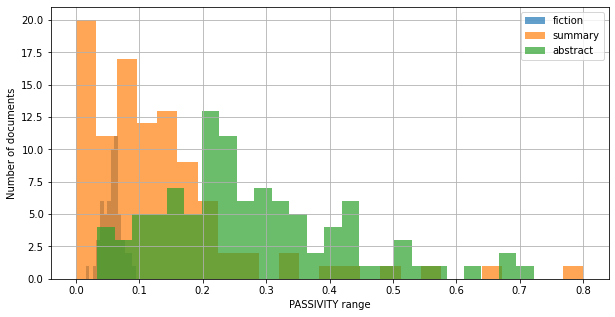

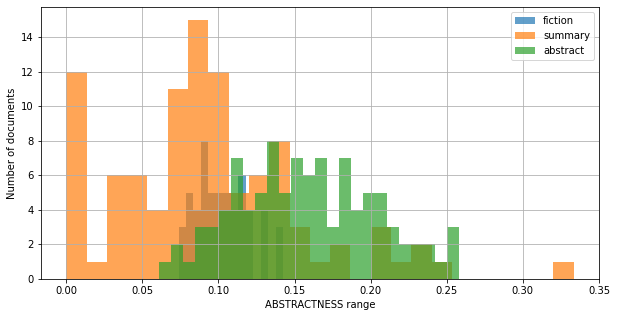

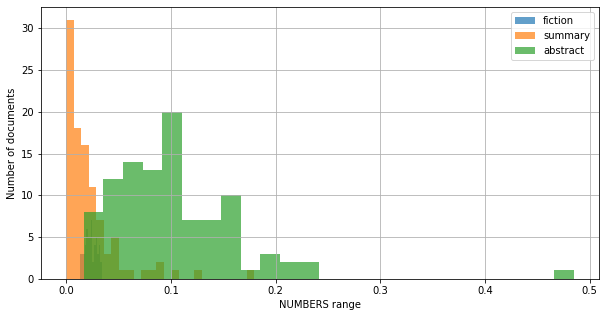

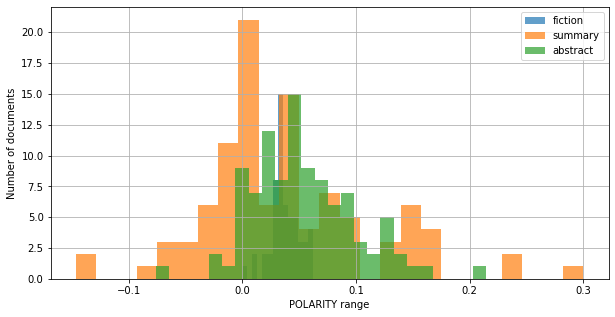

In [29]:
for feat in ['PASSIVITY', 'ABSTRACTNESS', 'NUMBERS', 'POLARITY']:
    graph_dist(features, feat);

Interestingly, the sentiment score does not appear to be particularly separable. All of our classes are mostly lumped together in terms of magnitude and range. We'll need to keep this in mind when building our model – in fact we may even toss this feature out altogether. On the other hand, our three other features seem like they will serve our model well. There's good separation between the classes, and within the classes themselves the features appear to be fairly well distributed.

Modeling II: Features
-------------------------